In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import talib as ta
import matplotlib.pyplot as plt

#machine learning scikit-learn
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.linear_model import LassoCV,Lasso
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.model_selection import cross_val_score

#fetching data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

### Data pre-processing

In [2]:
underlying = '600789.SS'#鲁抗医药
st = '2009-01-01'
et = '2019-01-01'

data = pdr.get_data_yahoo(underlying,st,et)
data = data.dropna()
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-05,2.63846,2.69231,2.62308,2.69231,2.646524,7486540
2009-01-06,2.69231,2.80769,2.66923,2.80000,2.752383,10326932
2009-01-07,2.80000,2.89231,2.76154,2.80000,2.752383,10453748
2009-01-08,2.75385,2.80769,2.70769,2.73077,2.684330,6613986
2009-01-09,2.73077,2.86154,2.73077,2.82308,2.775070,11798625


In [3]:
n = 10

data['high']=data['High'].shift(1)
data['low']=data['Low'].shift(1)
data['close']=data['Close'].shift(1)
data['RSI']=ta.RSI(np.array(data['close']), timeperiod=n)
data['SMA']= data['close'].rolling(window=n).mean()
data['Corr']= data['SMA'].rolling(window=n).corr(data['close'])
data['SAR']=ta.SAR(np.array(data['high']),np.array(data['low']),\
                  0.2,0.2)
data['ADX']=ta.ADX(np.array(data['high']),np.array(data['low']),\
                  np.array(data['close']), timeperiod =n)

data['Corr'][data.Corr>1]=1
data['Corr'][data.Corr<-1]=-1 
data['Return']= np.log(data['Open']/data['Open'].shift(1))

data=data.dropna()

data.columns

factors = ['Volume', 'RSI', 'SMA', 'Corr', 'SAR', 'ADX']
split = int(0.7*len(data))

X = data[factors]
y = data['Return']

x_train,y_train,x_test,y_test = X[:split],y[:split],X[split:],y[split:]

### Model 1 Linear Regression 

In [4]:
model = LinearRegression()
model.fit(x_train,y_train)

print('系数：',model.coef_)
print('模型：',model)

# data['Predicted'] = model.predict(x_test)
predicted = model.predict(x_test)
data['Predicted'] =data['Return']  
data['Predicted'][split:] = predicted

accuracy = model.score(x_test, y_test)
print('accuracy :', accuracy)

系数： [ 3.55249418e-10  5.25804578e-04  8.05617968e-03 -7.80705310e-04
 -1.12106977e-02 -2.47414880e-04]
模型： LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
accuracy : 0.09043487768323899


### Model 2 Lasso

In [5]:
model2 = LassoCV(alphas=np.logspace(-5,2,200),cv = 15)  #根据CV过程自动选择lambda
model2.fit(x_train,y_train)
print('系数:',model2.coef_)
print('模型',model2)

predicted2 = model2.predict(x_test)

data['Predicted2'] =data['Return']  
data['Predicted2'][split:] = predicted2

accuracy = model2.score(x_test, y_test)
print('accuracy :', accuracy)

系数: [ 3.65135790e-10  5.25320311e-04  4.78060694e-03 -1.15830375e-04
 -8.04459093e-03 -2.63954546e-04]
模型 LassoCV(alphas=array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149e-05, 2.86606762e-05, 3.10786619e-05, 3.37006433e-05,
       3.65438307e-05, 3.96268864e-05, 4.29700470e-05, 4.65952567e-05,
       5.05263107e-05, 5.47890118e-0...
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
        copy_X=True, cv=15, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)
accuracy : 0.0775830754263

## Model 3 Ridge

In [6]:
model3 = RidgeCV(alphas=np.logspace(-5,2,200),cv= 15,normalize=True)  #根据CV过程自动选择lambda
model3.fit(x_train,y_train)
print('系数:',model3.coef_)
print('模型',model3)

predicted3 = model3.predict(x_test)

data['Predicted3'] =data['Return']  
data['Predicted3'][split:] = predicted3

accuracy = model3.score(x_test,y_test)
print('accuracy :', accuracy)

系数: [ 3.55277566e-10  5.25804756e-04  8.04537905e-03 -7.80405888e-04
 -1.12002089e-02 -2.47448097e-04]
模型 RidgeCV(alphas=array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149e-05, 2.86606762e-05, 3.10786619e-05, 3.37006433e-05,
       3.65438307e-05, 3.96268864e-05, 4.29700470e-05, 4.65952567e-05,
       5.05263107e-05, 5.47890118e-0...
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
        cv=15, fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
        store_cv_values=False)
accuracy : 0.090

### Visualization

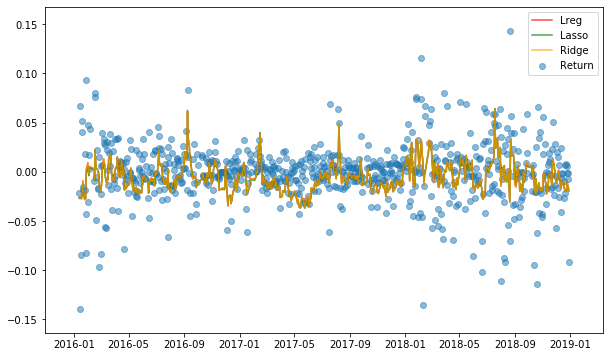

In [7]:
# data = data.reset_index(drop=False).rename(columns={'index':'Date'})
# print(data.index)
plt.figure(figsize=(10,6))

plt.scatter(data[split:].index,y_test,label= 'Return',alpha = 0.5)
plt.plot(data[split:].index, predicted,label= 'Lreg',alpha=0.7,color = 'red',)
plt.plot(data[split:].index,predicted2,label= 'Lasso',alpha=0.7,color = 'green')
plt.plot(data[split:].index,predicted3,label= 'Ridge',alpha=0.7,color = 'orange')

plt.legend()
plt.show()

### Strategy

In [8]:
# data['Return'] = np.log(data['Close']/data['Close'].shift(1)) #今日的return

data['Signal_pred'] = 0  #预测明日的涨跌情况
data['Signal_pred2'] =0
data['Signal_pred3'] =0

# data.loc[data['Predicted'].shift(-1)>data['Predicted'],'Signal_pred']= 1
# data.loc[data['Predicted'].shift(-1)<data['Predicted'],'Signal_pred']= 0
data['Signal_pred'][split:]=np.where(data['Predicted'][split:].shift(-1)>0,1,0)
data['Signal_pred2'][split:]=np.where(data['Predicted2'][split:].shift(-1)>0,1,0)
data['Signal_pred3'][split:]=np.where(data['Predicted3'][split:].shift(-1)>0,1,0)

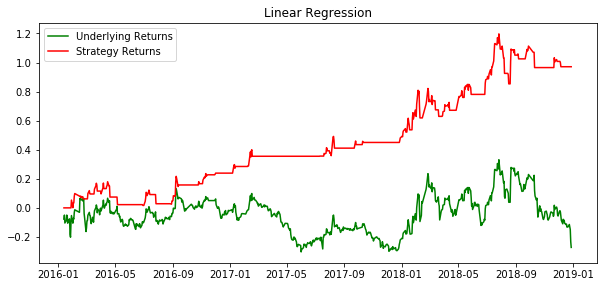

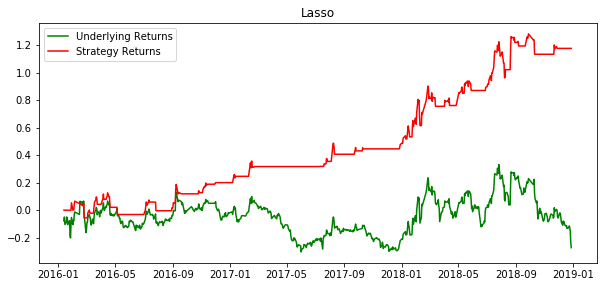

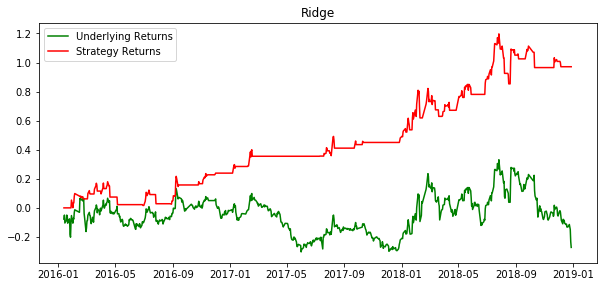

In [44]:
#Linear Regression
data['Startegy_returns'] = data['Return'] * data['Signal_pred'].shift(1) 
Cumulative_underlying_returns =np.cumsum(data['Return'][split:]) 

Cumulative_Strategy_returns = np.cumsum(data['Startegy_returns'][split:])

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(Cumulative_underlying_returns,color = 'g',label = 'Underlying Returns')
plt.plot(Cumulative_Strategy_returns,color = 'r',label = 'Strategy Returns')
plt.legend()
plt.title("Linear Regression")
plt.show()

#Lasso
data['Startegy_returns2'] = data['Return'] * data['Signal_pred2'].shift(1)

Cumulative_Strategy_returns2 = np.cumsum(data['Startegy_returns2'][split:])

plt.figure(figsize=(10,15))
plt.subplot(312)
plt.plot(Cumulative_underlying_returns,color = 'g',label = 'Underlying Returns')
plt.plot(Cumulative_Strategy_returns2,color = 'r',label = 'Strategy Returns')
plt.legend()
plt.title("Lasso")
plt.show()

#Ridge
data['Startegy_returns3'] = data['Return'] * data['Signal_pred3'].shift(1)

Cumulative_Strategy_returns3 = np.cumsum(data['Startegy_returns3'][split:])

plt.figure(figsize=(10,15))
plt.subplot(313)
plt.plot(Cumulative_underlying_returns,color = 'g',label = 'Underlying Returns')
plt.plot(Cumulative_Strategy_returns3,color = 'r',label = 'Strategy Returns')
plt.legend()
plt.title("Ridge")
plt.show()